## Data Preprocessing Pipeline

The goal of this notebook is to prepare the data for the machine learning models. The data is prepared in the following steps:
1. Load the data for each subject and group the data according to the exercise number
2. Preprocess the data for each exercise using the bandpass filter
3. Split the data into training, validation and test sets
4. Perform windowing
5. Perform feature extraction

As of now, we only focus on first exercise. The result of this notebook is a dictionary containing the training, validation and test sets for each subject. You can load this dictionary in the next notebook and use it to train the machine learning models. See [modelling notebook](modelling.ipynb) for more details.

If you want to obtain new version of the preprocessed data, i.e., you want to run this notebook with different parameters, please, first make sure you have downloaded the [ninapro dataset](https://drive.google.com/file/d/1XVe8XQQofxpCT2oFuBZpfE6uJ2oCqcoC/view?usp=sharing) and placed in the data folder. Of course, make sure it is unzipped. The folder should then include data for 27 subjects. Then, you can run this notebook.

### Setup

---

To reload custom scripts automatically:

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define dependencies:

In [37]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import pandas as pd
from scipy import signal

import os
import pickle
from tqdm import tqdm
import sys
sys.path.insert(0, '../')

from IPython.display import clear_output

from src import utils

Define global variables:

In [38]:
DATA_ROOT = os.path.join("..", "data")
NINAPRO_ROOT = os.path.join("..", "data", "ninapro")
SAMPLING_EMG_RATE = 100
USE_REP = False # Whether to use the entire repetition as the window

### Load Data and Preprocess Data

---

We are using [NinaPro](http://ninaweb.hevs.ch/) dataset for this project. The dataset is available in the `data` folder. The dataset includes sEMG and kinematic data from 27 intact subjects while repeating 52 hand movements plus the rest position. For the scope of this project, we will only use the sEMG data.

The sEMG data were acquired using 10 Otto Bock MyoBock 13E200 electrodes. The dataset includes 10 repetitions of 52 different movements. The subjects are asked to repeat movements which were shown as movies on the screen of a laptop. Each movement repetition lasts 5s and is followed by 3 s of rest. The experiment is divided in three exercises:

1. Basic movements of the fingers.
2. Isometric, isotonic hand configurations and basic wrist movements.
3. Grasping and functional movements.

Therefore, for each exercise, for each subject, the database contains one matlab file with synchronized variables. The variables included in the matlab files are:
- Subject: subject number.
- Exercise: exercise number.
- Emg (10 columns): sEMG signal. Columns 1-8 are the electrodes equally spaced around the forearm at the height of the radio humeral joint. Columns 9 and 10 contain signals from the main activity spot of the muscles flexor and extensor digitorum superficialis.
- Stimulus (1 column): the movement repeated by the subject, according to the displayed movie.
- Restimulus (1 column): the movement repeated by the subject, but with the duration of the movement label refined a-posteriori in order to better correspond to the real movement. 
- Repetition (1 column): repetition of the stimulus.
- Rerepetition (1 column): repetition of restimulus.

Let's start with the overview of the subjects:

In [4]:
subjects = pd.read_csv(os.path.join(NINAPRO_ROOT, "subjects.csv"))
subjects.head()

,Subject,Hand,Handedness,Gender,Age,Height,Weight
0,1,Intact,Right,Male,31,170,75
1,2,Intact,Right,Male,27,170,62
2,3,Intact,Right,Male,22,180,85
3,4,Intact,Right,Male,27,183,95
4,5,Intact,Right,Male,27,178,75


Now, we will pefrom some basic data exploration to get a better understanding of the subjects:

In [5]:
male_n, female_n = subjects.Gender.value_counts()
print(f"ℹ️ There are {male_n} males and {female_n} females in the dataset.")

right, left = subjects['Handedness'].value_counts()
print(f"ℹ️ There are {left} left-handed and {right} right-handed subjects in the dataset.")

pd.DataFrame([subjects['Age'].describe(), subjects['Height'].describe(), subjects['Weight'].describe()])

ℹ️ There are 20 males and 7 females in the dataset.
ℹ️ There are 2 left-handed and 25 right-handed subjects in the dataset.


,count,mean,std,min,25%,50%,75%,max
Age,27.0,28.592593,4.235920,22.0,26.5,28.0,30.0,40.0
Height,27.0,173.148148,8.263468,155.0,167.5,173.0,180.0,185.0
Weight,27.0,69.407407,12.530760,48.0,61.0,67.0,75.5,100.0


To make our life easier, we will parse the data for each exercise into a numpy array in a following fashion:

1. For each subject we load the emg data and corresponding stimulus and repetiion labels. These come as 2D arrays where each row corresponds to a timestamp. Therefore, in each row we will have info about the raw emg signal, stimilus, repetition and subject id.

2. We will then concatenate all the subjects into a single numpy array. In other words, we will stack the 2d arrays on top of each other. This way, we can later choose easily which subjects to use for training and which for testing.

If needed in the later stage, we can also merge the data from all three exercises into a single numpy array. But for the start, it is easier to try training the model for recognizing the movements from each exercise separately.

In [6]:
subject_ids = subjects['Subject'].unique().tolist()
exercise_ids = [1, 2, 3]

for ex in exercise_ids:
    print(f"ℹ️ Parsing exercise {ex}")
    exercise = utils.parse_exercise_data(NINAPRO_ROOT, subject_ids, ex)
    print(f"ℹ️ Exercise {ex} has shape {exercise.shape}")

    save_path = os.path.join(DATA_ROOT, f"exercise_{ex}.npy")
    np.save(save_path, exercise)
    print(f"✅ Successfully saved to {save_path}.\n")

ℹ️ Parsing exercise 1


Loading data for exercise 1: 100%|██████████| 27/27 [00:02<00:00, 13.19it/s]


ℹ️ Exercise 1 has shape (2731393, 13)
✅ Successfully saved to ../data/exercise_1.npy.

ℹ️ Parsing exercise 2


Loading data for exercise 2: 100%|██████████| 27/27 [00:03<00:00,  7.16it/s]


ℹ️ Exercise 2 has shape (3868568, 13)
✅ Successfully saved to ../data/exercise_2.npy.

ℹ️ Parsing exercise 3


Loading data for exercise 3: 100%|██████████| 27/27 [00:04<00:00,  5.72it/s]


ℹ️ Exercise 3 has shape (5953650, 13)
✅ Successfully saved to ../data/exercise_3.npy.



Let's check the sizes of the extracted numpy arrays:

In [7]:
!du -h ../data/exercise_1.npy
!du -h ../data/exercise_2.npy
!du -h ../data/exercise_3.npy

272M	../data/exercise_1.npy
384M	../data/exercise_2.npy
592M	../data/exercise_3.npy


### Exercise Data Inspection

---

Start by loading:

In [8]:
exercises = []
for ex in exercise_ids:
    exercise = np.load(os.path.join(DATA_ROOT, f"exercise_{ex}.npy"))
    print(f"✅ Exercise {ex} loaded, it has {exercise.shape[0]} rows and {exercise.shape[1]} columns.")
    exercises.append(exercise)

✅ Exercise 1 loaded, it has 2731393 rows and 13 columns.
✅ Exercise 2 loaded, it has 3868568 rows and 13 columns.
✅ Exercise 3 loaded, it has 5953650 rows and 13 columns.


Then, let's do some basic data exploration:

In [9]:
total_stimuli = 0
for i, exercise in enumerate(exercises):

    # Number of samples per subject
    samples_per_subject = exercise.shape[0] // len(subject_ids)

    # Number of minutes per subject
    minutes_per_subject = samples_per_subject / SAMPLING_EMG_RATE / 60

    # Number of minutes in total
    minutes_total = minutes_per_subject * len(subject_ids)

    # Unique stimulus and repetitions
    stimuli, rep = exercise[:, 10], exercise[:, 11]
    stimuli_unique = np.unique(stimuli)
    total_stimuli += len(stimuli_unique) - 1 # -1 because 0 is not a stimulus but a rest
    rep_unique = np.unique(rep)
    assert (len(rep_unique) - 1) == 10, "❌ There should be 10 repetitions per stimulus." # -1 because 0 is not a repetition but a rest

    print(f"ℹ️ Exercise {i+1} has {len(subject_ids)} subjects, {samples_per_subject} samples per subject, {minutes_per_subject:.2f} minutes per subject, {minutes_total:.2f} minutes in total, {len(stimuli_unique) - 1} unique stimuli and {len(rep_unique)} unique repetitions.")

assert total_stimuli == 52, "❌There should be 52 unique stimuli in total."
print("✅ There are 52 unique stimuli in total.")
print("✅ Each exercise has 10 repetitions per stimulus.")

ℹ️ Exercise 1 has 27 subjects, 101162 samples per subject, 16.86 minutes per subject, 455.23 minutes in total, 12 unique stimuli and 11 unique repetitions.
ℹ️ Exercise 2 has 27 subjects, 143280 samples per subject, 23.88 minutes per subject, 644.76 minutes in total, 17 unique stimuli and 11 unique repetitions.
ℹ️ Exercise 3 has 27 subjects, 220505 samples per subject, 36.75 minutes per subject, 992.27 minutes in total, 23 unique stimuli and 11 unique repetitions.
✅ There are 52 unique stimuli in total.
✅ Each exercise has 10 repetitions per stimulus.


These numbers are in line with the description of the dataset:
- The exercises last respectively 16, 23, and 31 minutes. Subjects are allowed short breaks between exercises to avoid muscle fatigue, such that the total duration of the experiment is around 100 minutes.
- To reduce variability, the sequence of movements is not randomized in order to induce unconscious movement repetitions into the subjects.

### Exercise Data Preprocessing

---

Based on the following [paper](https://www.nature.com/articles/sdata201453), the data was preprocessed in the following ways:

1. **Synchronization**: high-resolution timestamps were used to synchronize the data streams. Specifically, all streams were super-sampled to the highest sampling frequency (100 Hz) using linear interpolation (real-valued streams)

2. **Relabelling**: The movements performed by the subjects may not perfectly match with the stimuli proposed by our software due to human reaction times and experimental conditions. The resulting erroneous movement labels have been corrected by applying a generalized likelihood ratio algorithm, which realigns the movement boundaries by maximizing the likelihood of a rest-movement-rest sequence. Both the original labels and the new labels are included in the files.

We will perform the following **additional** preprocessing steps:

1. **Bandpass filtering**: we perform the exact same filtering as the authors of the DB1 dataset described in their [paper](https://ieeexplore.ieee.org/document/6825822?arnumber=6825822). Specifically, they low-pass filtered the sEMG signals at a cutoff frequency of `5 Hz` using a zero-phase second-order Butterworth filter. As Atzori et al. argues, the Otto Bock electrodes already applied Root Mean Square filtering which motivated the choice of the loss pass filter. If there was no such filtering, we would likely use more standard `15-450 Hz` bandpass filter.

In [10]:
# Cutoff frequency for low-pass filter
cutoff_frequency = 5

for ex, exercise in enumerate(exercises):
    # Design a zero-phase second-order Butterworth low-pass filter
    sos = signal.butter(N=2, Wn=cutoff_frequency, fs=SAMPLING_EMG_RATE, btype="low", output="sos")
    
    # Apply the filter to the sEMG signal
    EMG = exercise[:, :10]
    EMG = signal.sosfiltfilt(sos, EMG.T).T

    # Save the filtered signal
    save_path = os.path.join(DATA_ROOT, f"exercise_{ex + 1}_emg_processed.npy")
    np.save(save_path, EMG)

print("✅ All exercises filtered and saved.")

✅ All exercises filtered and saved.


### Visualization of the Prepared Data

---

Let's start with visualizing the first exercise data.

In [11]:
# Load the firt exercise
emg1 = np.load(os.path.join(DATA_ROOT, "exercise_1_emg_processed.npy"))
df1 = pd.DataFrame(np.load(os.path.join(DATA_ROOT, "exercise_1.npy"))[:, -3:], columns=["Stimulus", "Repetition", "Subject"], dtype=int)
id2stimulus = {
    0: "Rest",
    1: "Index flexion",
    2: "Index extension",
    3: "Middle flexion",
    4: "Middle extension",
    5: "Ring flexion",
    6: "Ring extension",
    7: "Little flexion",
    8: "Little extension",
    9: "Thumb adduction",
    10: "Thumb abduction",
    11: "Thumb flexion",
    12: "Thumb extension",
}

id2color = {
    0: "gray",
    1: "red",
    2: "lightcoral",    # Lighter shade of red
    3: "green",
    4: "limegreen",     # Lighter shade of green
    5: "blue",
    6: "deepskyblue",   # Lighter shade of blue
    7: "purple",
    8: "mediumpurple",  # Lighter shade of purple
    9: "darkorange",
    10: "orange",   # Lighter shade of orange
    11: "gold",
    12: "khaki",  # Lighter shade of yellow
}

# Choose the subject and obtain the data
subject = 1
df1_subject = df1[df1["Subject"] == subject]
emg1_subject = emg1[df1_subject.index]

As a recap, Channels 1-8 are the electrodes equally spaced around the forearm at the height of the radio humeral joint. Columns 9 and 10 contain signals from the main activity spot of the muscles flexor and extensor digitorum superficialis. See the figure below for the electrode placement:

![electrode_placement](../figures/electrode_placement.png)

Now, let's see the activity accross the channels.

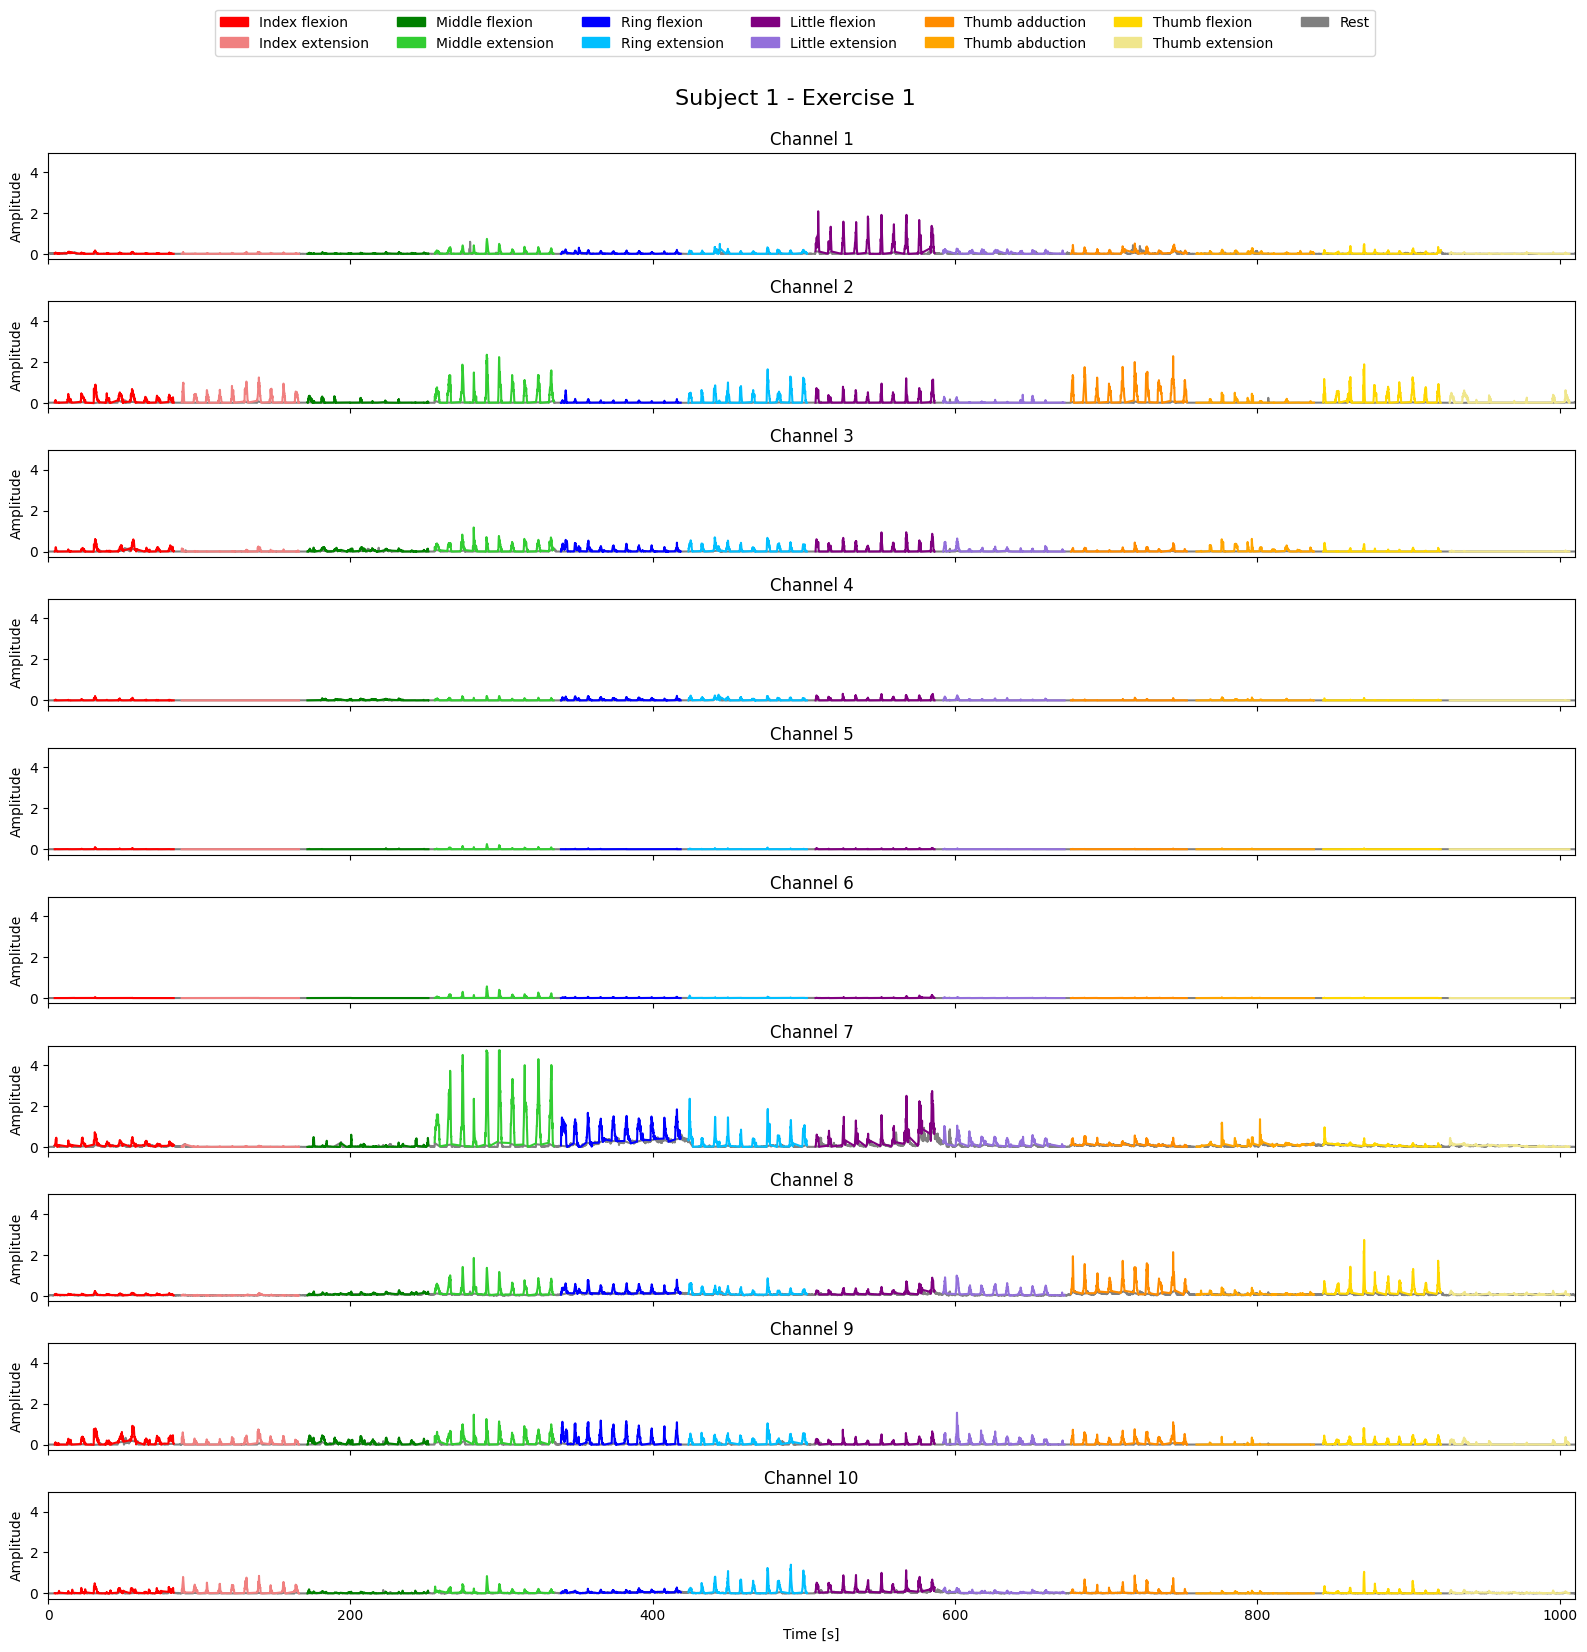

In [12]:
# Setup the plot
n_time, n_channels = emg1_subject.shape
fig,ax = plt.subplots(n_channels, 1, figsize = (16,16), sharex=True, sharey=True)

# Get the time vector
t = np.arange(0, n_time)/SAMPLING_EMG_RATE

# Plot the EMG signal for each channel
for i in range(n_channels):
    sns.lineplot(x=t, y=emg1_subject[:, i], ax=ax[i], hue=df1_subject["Stimulus"], palette=id2color, linewidth=1.5, legend=False)
    ax[i].set_title(f"Channel {i+1}")
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Amplitude")
    ax[i].set_xlim([0, t[-1]])


# Create a legend for the entire figure based on id2stimulus dictionary
legend_labels = [id2stimulus[i] for i in id2stimulus.keys()][1:] + ["Rest"]
legend_colors = [id2color[i] for i in id2color.keys()][1:] + ["gray"]

ncol = 7  # Number of columns per row
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

# Place the legend outside the plot
fig.legend(handles=legend_patches, loc='upper center', ncol=ncol, borderaxespad=0.05, bbox_to_anchor=(0.5, 1.03))

# Add the title for the entire figure
fig.suptitle(f"Subject {subject} - Exercise 1\n", fontsize=16)

plt.tight_layout()
plt.show()


For each channel, we can see 12 stimulus each repeeated 10 times (see the peaks). Interestingly, channels 4 - 6 does not seem to capture any activity relative to the other channels. This plot will be useful when we wll be windowing the data. In particuluar, after windowing, we should make sure that we shuffle the windows. Finally, notice, that the spikes' amplitude differs across the repetitions, therefore it is a good idea to have equal number of reps from the start as well from the end of the exercise for each type of hand gesture to account for the muscle fatigue and other confounding factors. In fact, let's zoom into one particular exercise and see how the activity changes over time:

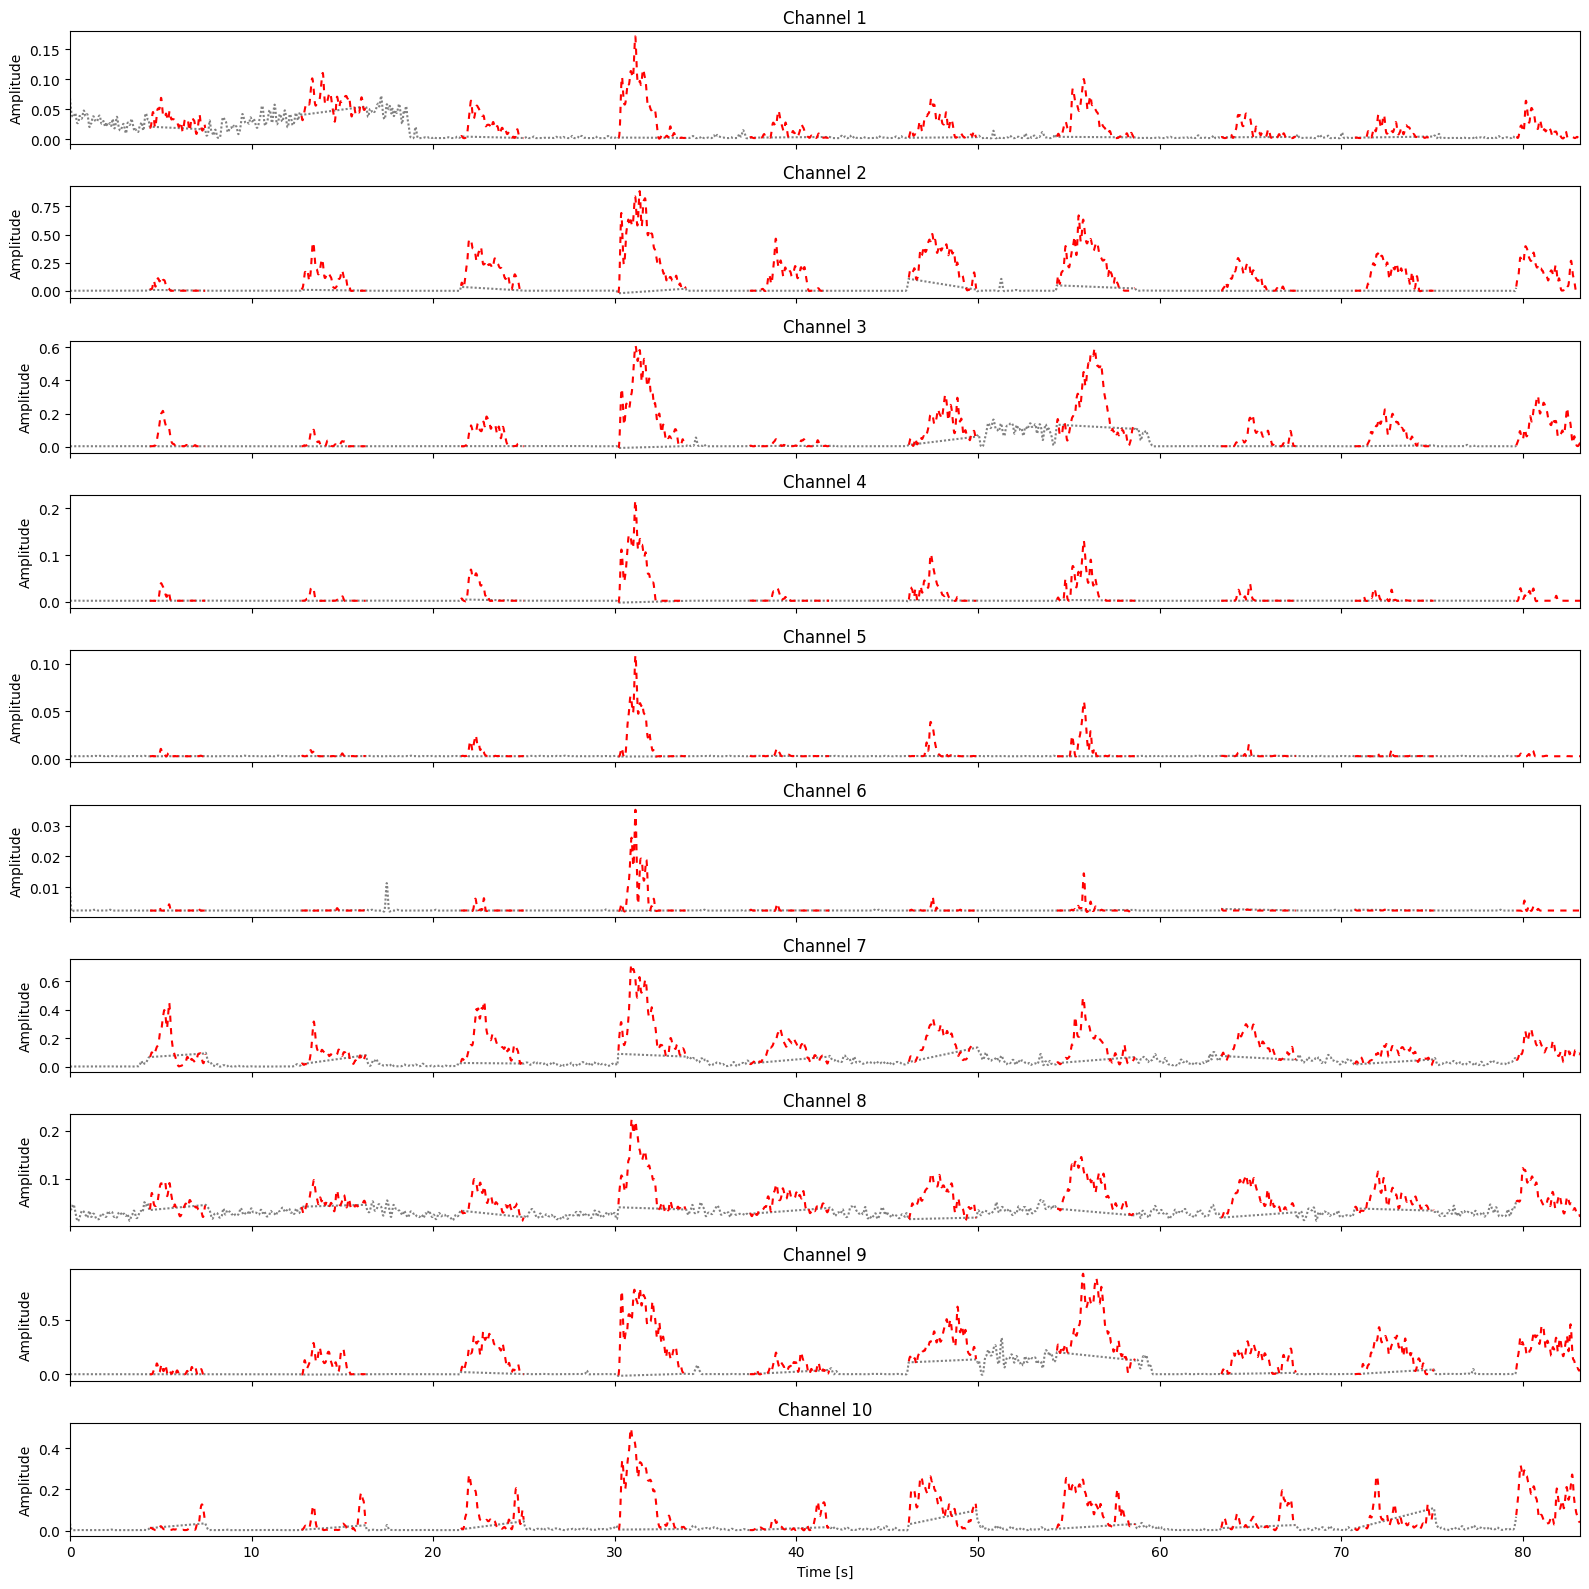

In [13]:
# Get indexes of the chosen stimulus and subject
df1_stimulus_index = df1[(df1["Stimulus"] == 1) & (df1["Subject"] == 1)].index.to_numpy()

# The above would exclude the rest periods, so we need to add them back
rest_index = df1[df1["Stimulus"] == 0].index.to_numpy()
relevant_rest = rest_index[np.where(rest_index < df1_stimulus_index[-1])]

# Combine the two indexes and sort them
df1_stimulus_index = np.sort(np.concatenate((df1_stimulus_index, relevant_rest)))

# Choose the appropriate rows from the EMG signal and df1
df1_stimulus = df1.loc[df1_stimulus_index]
emg1_stimulus = emg1[df1_stimulus_index]

assert emg1_stimulus.shape[0] == df1_stimulus_index.shape[0], "❌ The number of rows in the EMG signal should be equal to the number of rows in the dataframe."

# Define dash patterns
dash_dict = {style: (3, 3) if i % 2 == 0 else (3, 3) for i, style in enumerate([i for i in range(1, 11)])}
dash_dict[0] = (1, 1)  # Rest periods should not be dashed


# Setup the plot
n_time, n_channels = emg1_stimulus.shape
fig,ax = plt.subplots(n_channels, 1, figsize = (16,16), sharex=True)

# Get the time vector
t = np.arange(0, n_time)/SAMPLING_EMG_RATE

# Plot the EMG signal for each channel
for i in range(n_channels):
    sns.lineplot(x=t, y=emg1_stimulus[:, i], ax=ax[i], hue=df1_stimulus["Stimulus"], style=df1_stimulus["Repetition"], palette=id2color, linewidth=1.5, dashes = dash_dict, legend=False)
    ax[i].set_title(f"Channel {i+1}")
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Amplitude")
    ax[i].set_xlim([0, t[-1]])

plt.tight_layout()

As espected, we have spikes for given hand stimulus interleaved with the rest periods. In addition, we can see even more that there are clear differences in the spikes across repetitions. For instance, consider channel 4 or 5, and compare the 4 repetition to the rest.

### Train, Test, Split

---

Start by loading the data again, so we are sure we are using the same data as in the previous section.

In [39]:
emg1 = np.load(os.path.join(DATA_ROOT, "exercise_1_emg_processed.npy"))
df1 = pd.DataFrame(np.load(os.path.join(DATA_ROOT, "exercise_1.npy"))[:, -3:], columns=["Stimulus", "Repetition", "Subject"], dtype=int)
assert df1.shape[0] == emg1.shape[0], "❌ The number of rows in the dataframe and the number of samples in the EMG signal should be the same."
print("✅ The number of rows in the dataframe and the number of samples in the EMG signal are the same.")


✅ The number of rows in the dataframe and the number of samples in the EMG signal are the same.


Define the repetitions that will be assigned to the training, validation and  test sets, and then divide the data accordingly. Note that the repetitions are assigned in a way that all splits include early repetitions as well those towards the end of the experiment. This is done to ensure that the splits are representative of the whole experiment.

In [40]:
# Define the splits, resulting ratio should be around 0.5, 0.3, 0.2
train_reps = [1, 3, 5, 7, 9]
val_reps = [2, 4, 8]
test_reps = [6, 10]

# Split the data
df1 = utils.train_val_test_split(df1, val_reps, test_reps)

# Show the split percentage
split_percentage = pd.DataFrame([df1.value_counts("Split") / df1.shape[0] * 100], index=["Percentage"])
split_percentage

Split,train,val,test
Percentage,49.425274,29.889346,20.68538


The ratio is correct! Now, we can also visualize again the timeseries for a single subject accross channels and color the splits:

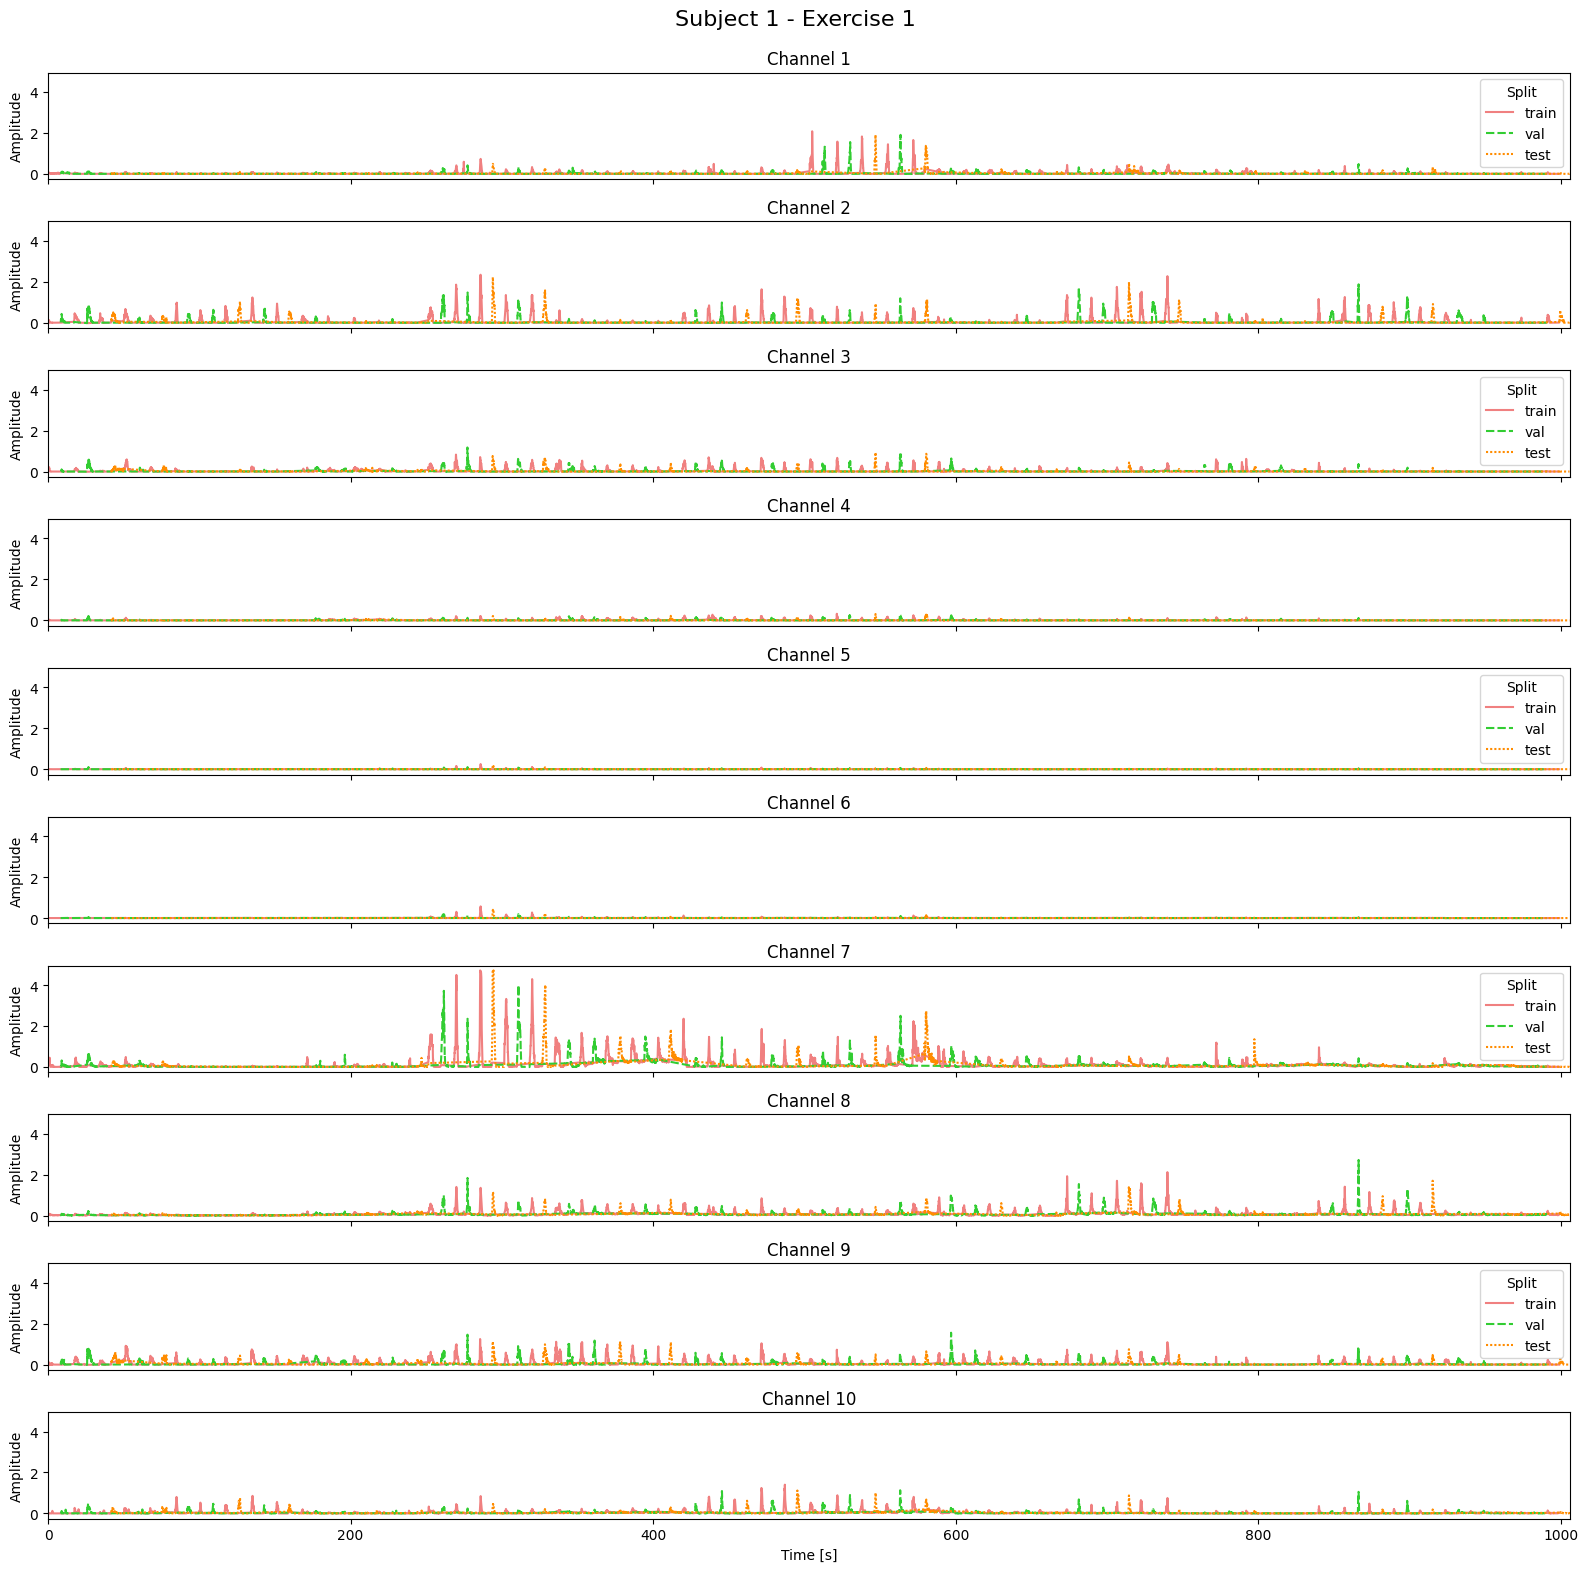

In [41]:
# Define the palette
split2color = {
    "train": "lightcoral",
    "val": "limegreen",
    "test": "darkorange"
}

# Subset the data for the given subject
df1_subject = df1[df1["Subject"] == subject]
emg1_subject = emg1[df1_subject.index]

# Setup the plot
n_time, n_channels = emg1_subject.shape
fig,ax = plt.subplots(n_channels, 1, figsize = (16,16), sharex=True, sharey=True)

# Get the time vector
t = np.arange(0, n_time)/SAMPLING_EMG_RATE

# Plot the EMG signal for each channel
for i in range(n_channels):
    allow_legend = True if i % 2 == 0 else False
    sns.lineplot(x=t, y=emg1_subject[:, i], ax=ax[i], hue=df1_subject["Split"], palette=split2color, style=df1_subject["Split"], linewidth=1.5, legend=allow_legend)
    ax[i].set_title(f"Channel {i+1}")
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Amplitude")
    ax[i].set_xlim([0, t[-1]])

# Add the title for the entire figure
fig.suptitle(f"Subject {subject} - Exercise 1\n", fontsize=16)

plt.tight_layout()
plt.show()

Great, we can see that we oscillate between the training, validation and test sets. This is good, because we want to make sure that the splits are representative of the whole experiment.

### Windowing

---

In this section, we will define the window length and the sliding step, which by definition determines the overlap between windows. We define the window length to be `500 ms` since this is a timespan of data which gives enough information and at the same time could still be possibly used in production to control protese. We choose the sliding window to be `100 ms` which provides a good balance between the computational cost (higher overlap, higher comp. cost) and the amount of data (lower overlap, less data). In particular, if we would choose the overlap to be too small, we risk losing too much information which will impact extracted features and the model performance. On the other hand, if we choose the overlap to be too large, we will have too much data which will increase the computational cost.

In [42]:
# Defint the hyperparameters
window_length = 0.500 # 500 ms
sliding_step = 0.1 # 100 ms --> window for every sample
subject_window = {subject_id: None for subject_id in df1.Subject.unique()}
time_labels = {subject_id: None for subject_id in df1.Subject.unique()}

for subject_id in tqdm(subject_window.keys()):

    # Subset the data for the given subject
    # Get the splits
    subject_mask = (df1["Subject"] == subject_id)
    train = df1[(df1["Split"] == "train") & subject_mask]
    val = df1[(df1["Split"] == "val") & subject_mask]
    test = df1[(df1["Split"] == "test") & subject_mask]

    # Labels
    y_train, y_val, y_test = train["Stimulus"].to_numpy(), val["Stimulus"].to_numpy(), test["Stimulus"].to_numpy()

    # Save the time labels for the later cross check of distributions
    time_labels[subject_id] = (y_train, y_val, y_test)

    # Raw EMG signal
    emg_train, emg_val, emg_test = emg1[train.index], emg1[val.index], emg1[test.index]

    # Reset the indexes
    train, val, test = train.reset_index(), val.reset_index(), test.reset_index()

    # Extract time windows, X is of shape (n_windows, window_length, n_channels)
    # -- Each window corresponds to a unique combination of stimulus and repetition
    if USE_REP:
        X_train, y_train = utils.extract_trial_windows(emg_train, train)
        X_val, y_val = utils.extract_trial_windows(emg_val, val)
        X_test, y_test = utils.extract_trial_windows(emg_test, test)
    
    # -- Classical sliding window approach
    else:
        X_train, y_train = utils.extract_time_windows(emg_train, y_train, SAMPLING_EMG_RATE, window_length, sliding_step)
        X_val, y_val = utils.extract_time_windows(emg_val, y_val, SAMPLING_EMG_RATE, window_length, sliding_step)
        X_test, y_test = utils.extract_time_windows(emg_test, y_test, SAMPLING_EMG_RATE, window_length, sliding_step)

    # Save the data
    subject_window[subject_id] = [X_train, y_train, X_val, y_val, X_test, y_test]

100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Let's examine the distribtion of labels before and after windowing:

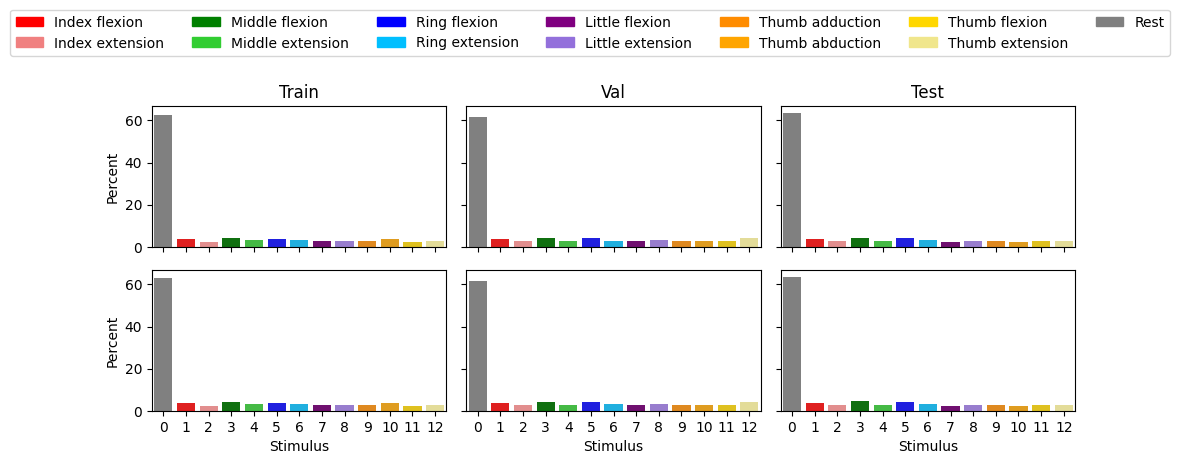

In [43]:
# Choose a subject
subject_id = 1

# Setup a figure
fig, axs = plt.subplots(2, 3, figsize=(10, 4), sharex=True, sharey=True)

# Get the training, validation and test labels
time_labels_subject = time_labels[subject_id]
_, y_train, _, y_val, _, y_test = subject_window[subject_id]
window_labels_subject = [y_train, y_val, y_test]

# Plot the dist of labels
for i, labels_subject in enumerate([time_labels_subject, window_labels_subject]):

    # Get the labels
    y_train, y_val, y_test = labels_subject
    
    # Plot the distribution of labels
    sns.countplot(x=y_train, ax=axs[i, 0], hue=y_train, palette=id2color, legend=False, stat='percent')
    sns.countplot(x=y_val, ax=axs[i, 1], hue=y_val, palette=id2color, legend=False, stat='percent')
    sns.countplot(x=y_test, ax=axs[i, 2], hue=y_test, palette=id2color, legend=False, stat='percent')

    # Set the title
    if i == 0:
        axs[i, 0].set_title("Train")
        axs[i, 1].set_title("Val")
        axs[i, 2].set_title("Test")

    # Set the x and y labels
    if i == 1:
        axs[i, 0].set_xlabel("Stimulus")
        axs[i, 1].set_xlabel("Stimulus")
        axs[i, 2].set_xlabel("Stimulus")
    
    axs[i, 0].set_ylabel("Percent")
    axs[i, 1].set_ylabel("Percent")

# Add the legend
legend_labels = [id2stimulus[i] for i in id2stimulus.keys()][1:] + ["Rest"]
legend_colors = [id2color[i] for i in id2color.keys()][1:] + ["gray"]
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
fig.legend(handles=legend_patches, loc='upper center', ncol=7, borderaxespad=0.05, bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()

We can see in the first row the distribution of labels based on timepoints and then in the second row distribution of labels based on windows. We can see that the distribution of labels is preserved. This is good, because we want to make sure that the splits are representative of the whole experiment. However, we can also see that we have way too many windows with `rest` label. This is because the rest periods are much longer than the movement periods. Therefore, we will need to balance the dataset in the next step.

In [44]:
for subject_id in subject_window.keys():

    # Get the data
    X_train, y_train, X_val, y_val, X_test, y_test = subject_window[subject_id]
    train, val, test = (X_train, y_train), (X_val, y_val), (X_test, y_test)

    # For each split, adjust the distribition of labels
    adjusted = []
    for split in [train, val, test]:
        X, y = utils.downsample_rest_windows(split)
        adjusted += [X, y]

    # Save the adjusted data
    subject_window[subject_id] = adjusted

Now, let's check the adjusted windowed data:

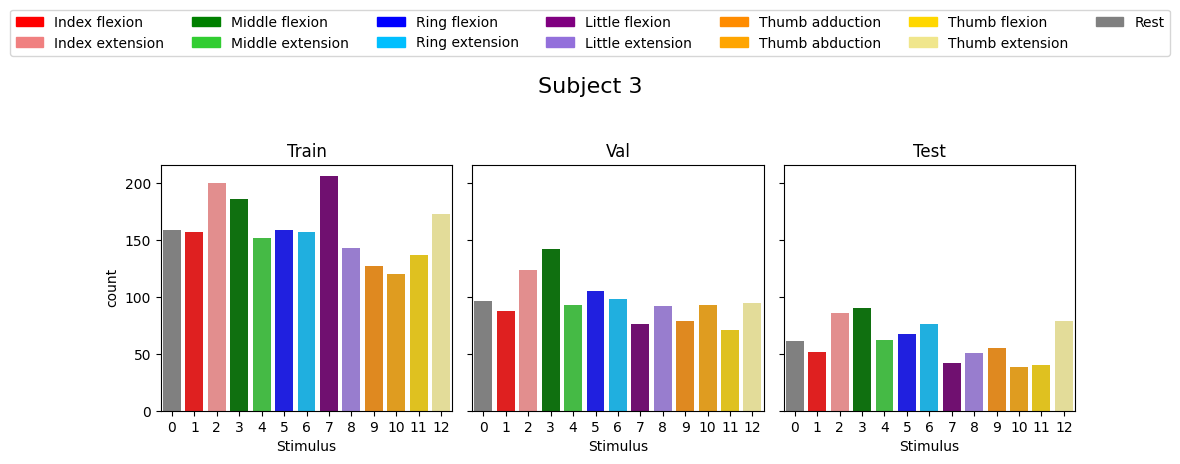

In [45]:
# Choose subject and statistic to display
subject_id = np.random.choice(list(subject_window.keys()))
stat = "count"

# Setup a figure
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

# Get the training, validation and test labels
_, y_train, _, y_val, _, y_test = subject_window[subject_id]

# Plot the dist of labels
sns.countplot(x=y_train, ax=axs[0], hue=y_train, palette=id2color, legend=False, stat=stat)
sns.countplot(x=y_val, ax=axs[1], hue=y_val, palette=id2color, legend=False, stat=stat)
sns.countplot(x=y_test, ax=axs[2], hue=y_test, palette=id2color, legend=False, stat=stat)

# Set the title
axs[0].set_title("Train")
axs[1].set_title("Val")
axs[2].set_title("Test")

# Set the x and y labels
axs[0].set_xlabel("Stimulus")
axs[1].set_xlabel("Stimulus")
axs[2].set_xlabel("Stimulus")

axs[0].set_ylabel(stat)

# Add the legend
legend_labels = [id2stimulus[i] for i in id2stimulus.keys()][1:] + ["Rest"]
legend_colors = [id2color[i] for i in id2color.keys()][1:] + ["gray"]
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
fig.legend(handles=legend_patches, loc='upper center', ncol=7, borderaxespad=0.05, bbox_to_anchor=(0.5, 1.15))

# Add the title for the entire figure
fig.suptitle(f"Subject {subject_id}\n", fontsize=16)

plt.tight_layout()

Great, we can see that that we do not have any sifnicant class imbalance anymore. In addition, we can see that indeed the absolute count of windows is on average smallest in the test set which is expected since we only assigned it 2 repetitions. In contrast, train dataset should have half of the repetition, which we can see in the plot as well.

### Feature Extraction

---

In this section, we will extract features from the windowed data. We will use the following features:

Time features: 

- Mean absolute value (MAV)
- Maximum absolute Value (MaxAV)
- Wavelength (WL): cumulative length of the waveform over time
- Standard Deviation (STD)
- Root mean square (RMS)

Frequency features: 

- Mean power 
- Total power
- Mean frequency
- Median frequency 
- Peak frequency

In [46]:
# Define the dict where we will save the data
subject_features = {subject_id: None for subject_id in df1.Subject.unique()}

for subject_id in tqdm(subject_features.keys()):
    # Get the data
    X_train, y_train, X_val, y_val, X_test, y_test = subject_window[subject_id]

    # Extract features
    X_train = utils.extract_features(X_train, SAMPLING_EMG_RATE)
    X_val = utils.extract_features(X_val, SAMPLING_EMG_RATE)
    X_test = utils.extract_features(X_test, SAMPLING_EMG_RATE)

    # Save the data
    subject_features[subject_id] = [X_train, y_train, X_val, y_val, X_test, y_test]

# Save the data so that it can then later be loaded
filename = "exercise_1_wind_processed.pkl" if USE_REP else "exercise_1_processed.pkl"
with open(os.path.join(DATA_ROOT, filename), 'wb') as file:
    pickle.dump(subject_features, file)

  0%|          | 0/27 [00:00<?, ?it/s]

/Users/ludekcizinsky/Dev/personal/emg-signal-movement-clf/notebooks/../src/utils.py:327: RuntimeWarning: invalid value encountered in divide
  mean_frequency = np.sum(fft_power * freqs_reshaped, axis=1) / tot_power
100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


Let's check the final size of the data:

In [47]:
!du -h ../data/exercise_1_processed.pkl

 99M	../data/exercise_1_processed.pkl


Let's check the number of windows/samples accross subjects for each split:

In [48]:
subjects_n_samples = {"train": [], "val": [], "test": []}
for subject_id in tqdm(subject_features.keys()):
    # Get the data
    X_train, y_train, X_val, y_val, X_test, y_test = subject_features[subject_id]

    # Get the number of samples
    n_train, n_val, n_test = X_train.shape[0], X_val.shape[0], X_test.shape[0]
    subjects_n_samples["train"].append(n_train)
    subjects_n_samples["val"].append(n_val)
    subjects_n_samples["test"].append(n_test)

    # Print the shape of each split
    print(f"👤 Subject {subject_id}")
    print(f"ℹ️ Train has {n_train}, val has {n_val} and test has {n_test} samples.\n")

100%|██████████| 27/27 [00:00<00:00, 29903.94it/s]

👤 Subject 1
ℹ️ Train has 2035, val has 1244 and test has 784 samples.

👤 Subject 2
ℹ️ Train has 2263, val has 1362 and test has 889 samples.

👤 Subject 3
ℹ️ Train has 2076, val has 1252 and test has 799 samples.

👤 Subject 4
ℹ️ Train has 2562, val has 1539 and test has 933 samples.

👤 Subject 5
ℹ️ Train has 3058, val has 1735 and test has 1146 samples.

👤 Subject 6
ℹ️ Train has 2590, val has 1530 and test has 1030 samples.

👤 Subject 7
ℹ️ Train has 2328, val has 1395 and test has 937 samples.

👤 Subject 8
ℹ️ Train has 1995, val has 1183 and test has 781 samples.

👤 Subject 9
ℹ️ Train has 2413, val has 1472 and test has 956 samples.

👤 Subject 10
ℹ️ Train has 2412, val has 1459 and test has 950 samples.

👤 Subject 11
ℹ️ Train has 2834, val has 1654 and test has 1113 samples.

👤 Subject 12
ℹ️ Train has 2472, val has 1552 and test has 1055 samples.

👤 Subject 13
ℹ️ Train has 1933, val has 1088 and test has 797 samples.

👤 Subject 14
ℹ️ Train has 2556, val has 1430 and test has 962 samples

We can see that there are some slight differences accross subjects, this could likely be that some subjects had longer rest periods than others, also could be due to the realigment of emg to labels. However, importantly, as we could see from the plot above, the distribution of stimulus is accross subjects similar. Let's look at the distribution of the samples to see if there is any signifficant imabalance:

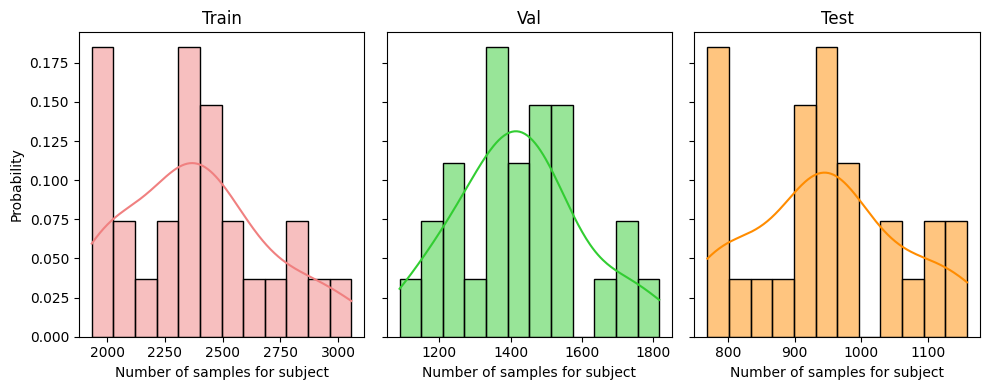

In [49]:
# Setup the figure
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

# Plot the distribution of samples accross subjects
sns.histplot(x=subjects_n_samples["train"], ax=axs[0], color="lightcoral", stat="probability", bins=12, kde=True);
sns.histplot(x=subjects_n_samples["val"], ax=axs[1], color="limegreen", stat="probability", bins=12, kde=True);
sns.histplot(x=subjects_n_samples["test"], ax=axs[2], color="darkorange", stat="probability", bins=12, kde=True);

# Set the title
axs[0].set_title("Train")
axs[1].set_title("Val")
axs[2].set_title("Test")

# Set the x and y labels
axs[0].set_xlabel("Number of samples for subject")
axs[1].set_xlabel("Number of samples for subject")
axs[2].set_xlabel("Number of samples for subject");

plt.tight_layout()

We can see sort of normal distribution, in addition, the difference between both extremes accross splits is not drastic. The conclusion is that we should have enough data to train the model, even when training on a single subject. Let's now check the quality of the extracted features by looking if there are any missing values:

In [50]:
miss_vals_splits = {"train": [], "val": [], "test": []}
for subject_id in subject_features.keys():
    # Get the data
    X_train, y_train, X_val, y_val, X_test, y_test = subject_features[subject_id]

    # Get the number of rows with missing values for each split
    nmiss_train, nmiss_val, nmiss_test = (np.isnan(X_train).sum(axis=1) > 0).sum(), (np.isnan(X_val).sum(axis=1) > 0).sum(), (np.isnan(X_test).sum(axis=1) > 0).sum()

    # Get the total number of samples
    n_train, n_val, n_test = X_train.shape[0], X_val.shape[0], X_test.shape[0]

    # Print the number of rows with missing values for each split
    print(f"👤 Subject {subject_id}")
    print(f"ℹ️ Train has {nmiss_train/n_train:.2f}, val has {nmiss_val/n_val:.2f} and test has {nmiss_test/n_test:.2f} rows with missing values.\n")

    # Save the values
    miss_vals_splits["train"].append(nmiss_train/n_train)
    miss_vals_splits["val"].append(nmiss_val/n_val)
    miss_vals_splits["test"].append(nmiss_test/n_test)


👤 Subject 1
ℹ️ Train has 0.02, val has 0.00 and test has 0.01 rows with missing values.

👤 Subject 2
ℹ️ Train has 0.00, val has 0.00 and test has 0.00 rows with missing values.

👤 Subject 3
ℹ️ Train has 0.00, val has 0.00 and test has 0.00 rows with missing values.

👤 Subject 4
ℹ️ Train has 0.00, val has 0.00 and test has 0.00 rows with missing values.

👤 Subject 5
ℹ️ Train has 0.00, val has 0.00 and test has 0.00 rows with missing values.

👤 Subject 6
ℹ️ Train has 0.00, val has 0.00 and test has 0.00 rows with missing values.

👤 Subject 7
ℹ️ Train has 0.01, val has 0.01 and test has 0.01 rows with missing values.

👤 Subject 8
ℹ️ Train has 0.01, val has 0.00 and test has 0.01 rows with missing values.

👤 Subject 9
ℹ️ Train has 0.00, val has 0.01 and test has 0.00 rows with missing values.

👤 Subject 10
ℹ️ Train has 0.00, val has 0.00 and test has 0.00 rows with missing values.

👤 Subject 11
ℹ️ Train has 0.01, val has 0.00 and test has 0.00 rows with missing values.

👤 Subject 12
ℹ️ Tra

Seems, like the biggest percentage accross splits is around 20 %, which is not too bad. Let's now check the distribution:

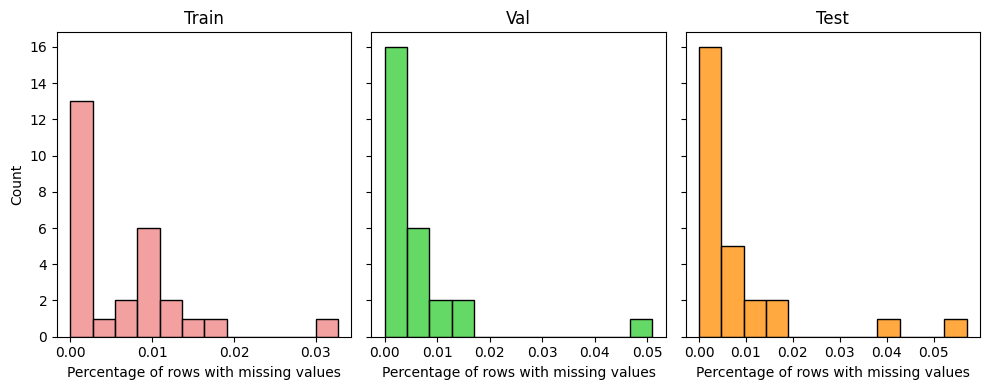

In [51]:
# Setup the figure
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

# Plot the distribution of missing samples accross subjects
sns.histplot(x=miss_vals_splits["train"], ax=ax[0], color="lightcoral", stat="count", bins=12);
sns.histplot(x=miss_vals_splits["val"], ax=ax[1], color="limegreen", stat="count", bins=12);
sns.histplot(x=miss_vals_splits["test"], ax=ax[2], color="darkorange", stat="count", bins=12);

# Set the title
ax[0].set_title("Train")
ax[1].set_title("Val")
ax[2].set_title("Test")

# Set the x and y labels
ax[0].set_xlabel("Percentage of rows with missing values")
ax[1].set_xlabel("Percentage of rows with missing values")
ax[2].set_xlabel("Percentage of rows with missing values");

plt.tight_layout()

Not too bad, we can see left skew, i.e., majority of subjects have less than 5 % of missing values. Now, we can drop the missing values:

In [52]:
for subject_id in subject_features.keys():

    # Get the data
    X_train, y_train, X_val, y_val, X_test, y_test = subject_features[subject_id]
    train, val, test = (X_train, y_train), (X_val, y_val), (X_test, y_test)

    # Drop rows with missing values
    adjusted = []
    for split in [train, val, test]:
        X, y = utils.drop_missing_values(split)
    
        # Save the adjusted data
        adjusted += [X, y]
    
    # Save the data
    subject_features[subject_id] = adjusted

Next, we check the disribution of stimulus accross splits for a random subject:

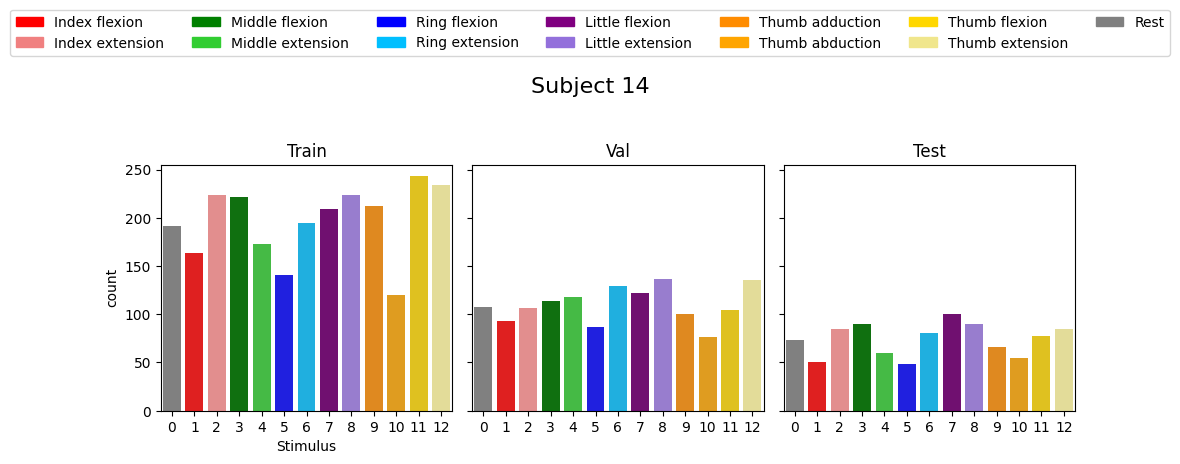

In [53]:
# Choose subject and statistic to display
subject_id = np.random.choice(list(subject_features.keys()))
stat = "count"

# Setup a figure
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

# Get the training, validation and test labels
_, y_train, _, y_val, _, y_test = subject_features[subject_id]

# Plot the dist of labels
sns.countplot(x=y_train, ax=axs[0], hue=y_train, palette=id2color, legend=False, stat=stat)
sns.countplot(x=y_val, ax=axs[1], hue=y_val, palette=id2color, legend=False, stat=stat)
sns.countplot(x=y_test, ax=axs[2], hue=y_test, palette=id2color, legend=False, stat=stat)

# Set the title
axs[0].set_title("Train")
axs[1].set_title("Val")
axs[2].set_title("Test")

# Set the x and y labels
axs[0].set_xlabel("Stimulus")

# Add the legend
legend_labels = [id2stimulus[i] for i in id2stimulus.keys()][1:] + ["Rest"]
legend_colors = [id2color[i] for i in id2color.keys()][1:] + ["gray"]
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

# Add the legend
fig.legend(handles=legend_patches, loc='upper center', ncol=7, borderaxespad=0.05, bbox_to_anchor=(0.5, 1.15))

# Add the title for the entire figure
fig.suptitle(f"Subject {subject_id}\n", fontsize=16)

plt.tight_layout()

Great, by dropping the missing values, we have not introduced any signifficant imbalance. Let's save the cleaned features:

In [54]:
filename = "exercise_1_wind_processed.pkl" if USE_REP else "exercise_1_processed.pkl"
with open(os.path.join(DATA_ROOT, filename), 'wb') as file:
    pickle.dump(subject_features, file)

And check the size of the saved data:

In [55]:
!du -h ../data/exercise_1_processed.pkl

 98M	../data/exercise_1_processed.pkl


### Feature Exploration

---

We have two types of features. First, time features (map the whole window to a single value): 

- Mean absolute value (`MAV`)
- Maximum absolute Value (`MaxAV`)
- Wavelength (`WL`): cumulative length of the waveform over time
- Standard Deviation (`STD`)
- Root mean square (`RMS`)

Frequency features: 

- Mean power 
- Total power
- Mean frequency
- Median frequency 
- Peak frequency

Let's dive into the time features first. We will start by looking at the distribution of the time features accross subjects for a single movement:

In [56]:
id2stimulus = {
    0: "Rest",
    1: "Index flexion",
    2: "Index extension",
    3: "Middle flexion",
    4: "Middle extension",
    5: "Ring flexion",
    6: "Ring extension",
    7: "Little flexion",
    8: "Little extension",
    9: "Thumb adduction",
    10: "Thumb abduction",
    11: "Thumb flexion",
    12: "Thumb extension",
}

id2color = {
    0: "gray",
    1: "red",
    2: "lightcoral",    # Lighter shade of red
    3: "green",
    4: "limegreen",     # Lighter shade of green
    5: "blue",
    6: "deepskyblue",   # Lighter shade of blue
    7: "purple",
    8: "mediumpurple",  # Lighter shade of purple
    9: "darkorange",
    10: "orange",   # Lighter shade of orange
    11: "gold",
    12: "khaki",  # Lighter shade of yellow
}

✅ Plots saved to ../figures/features/time/kde.


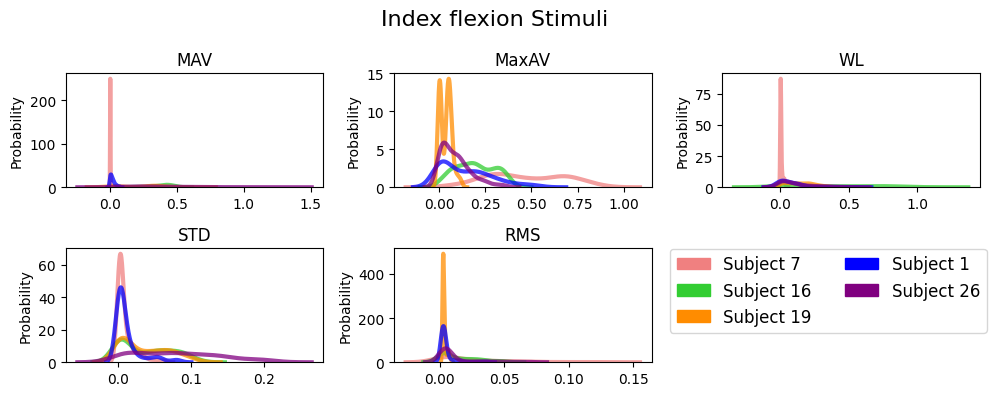

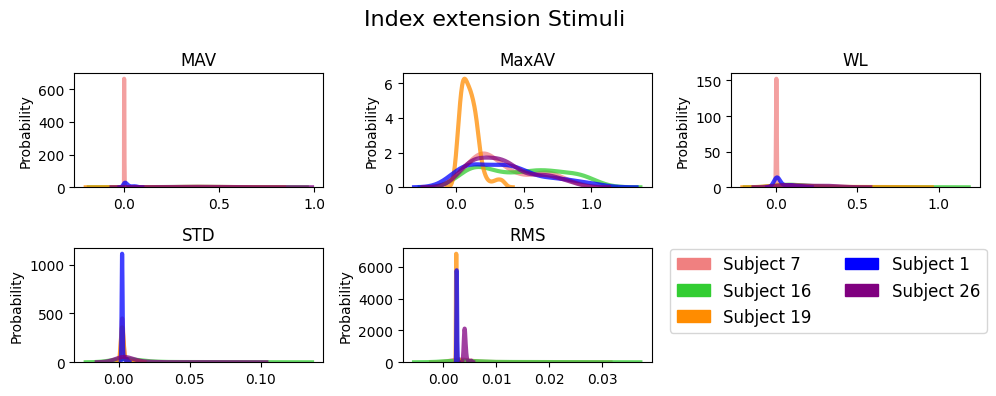

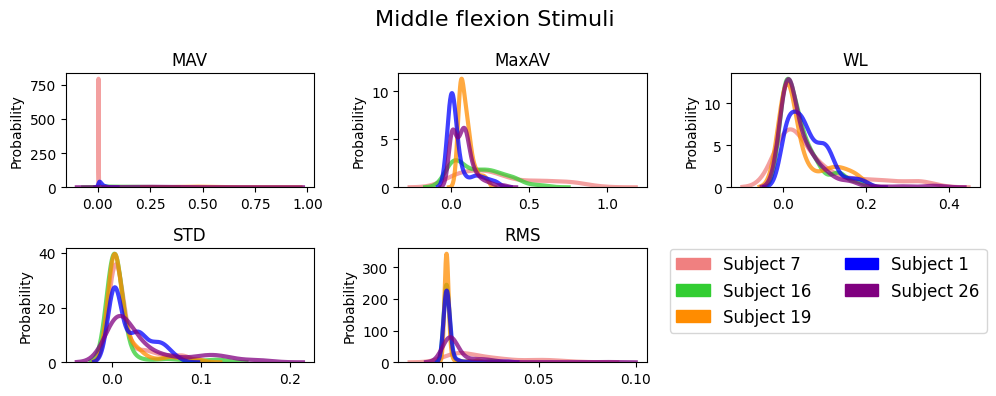

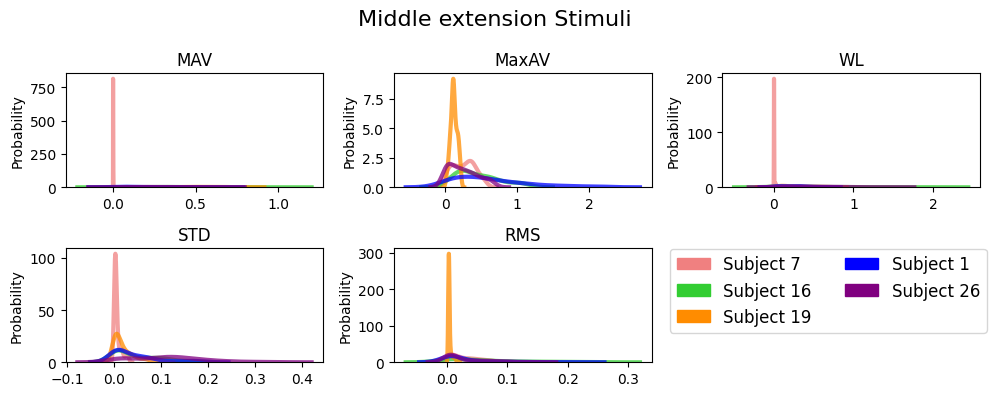

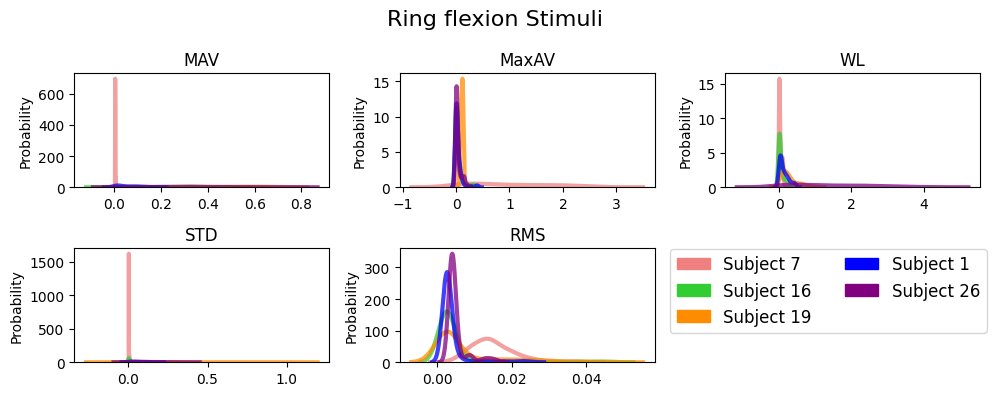

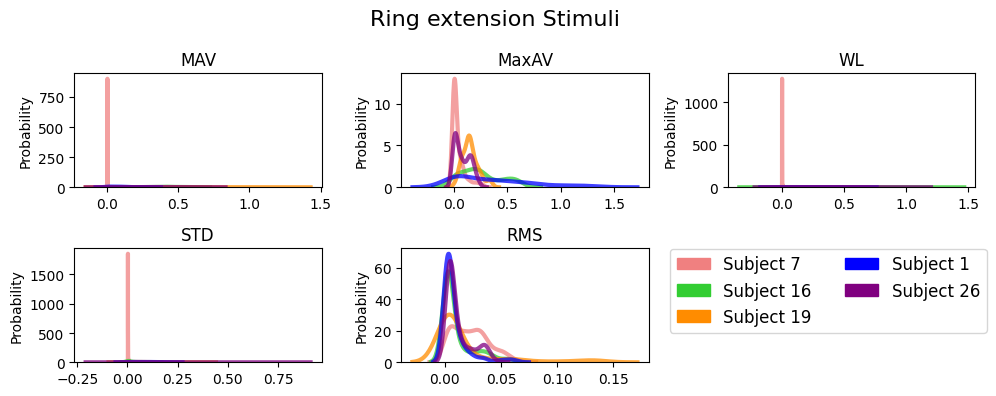

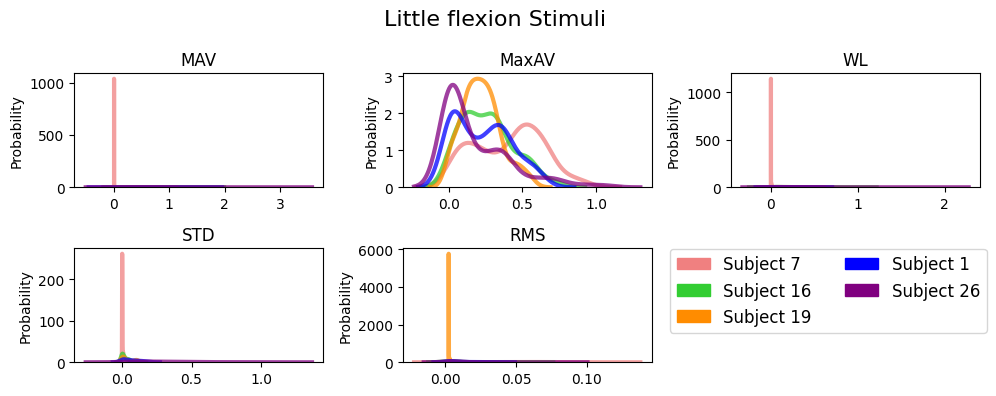

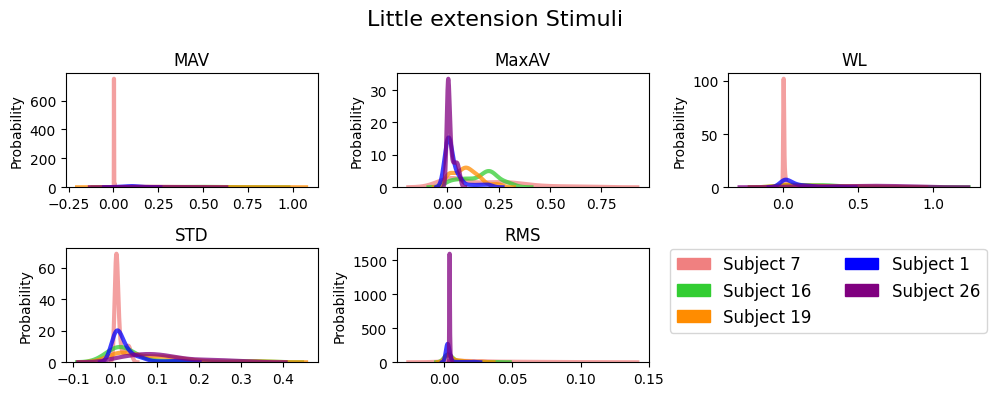

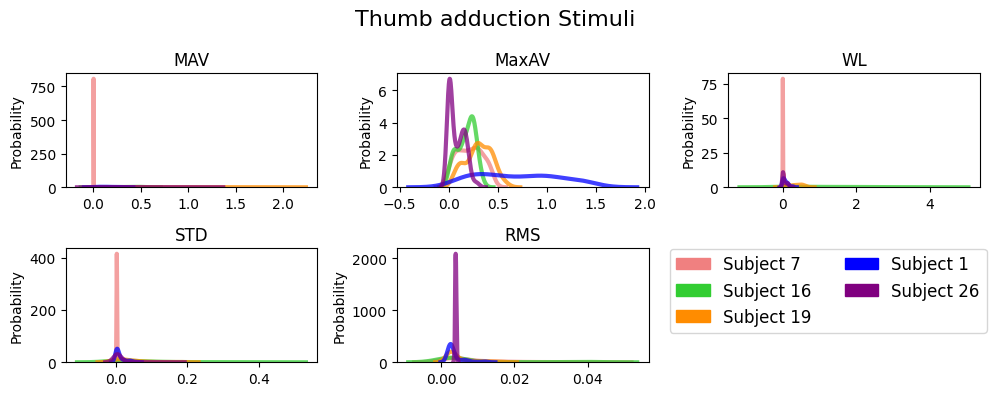

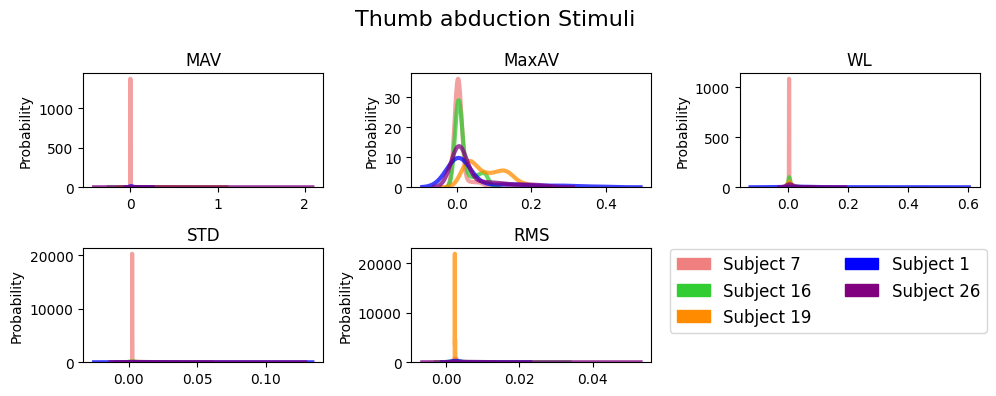

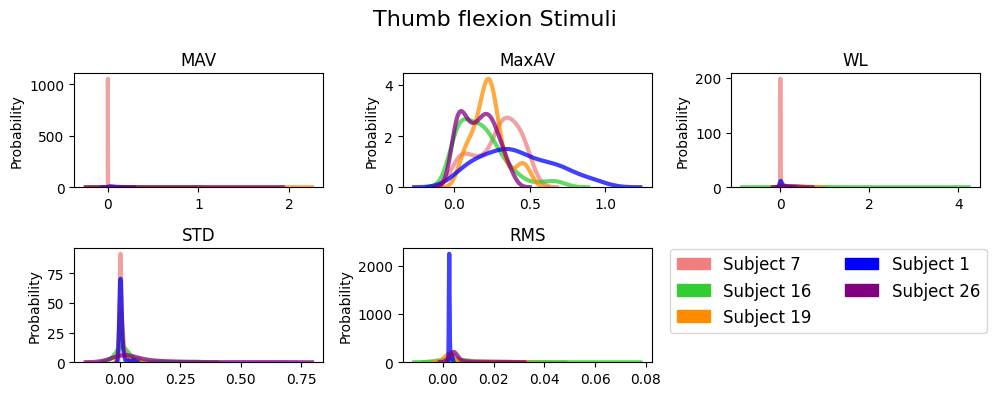

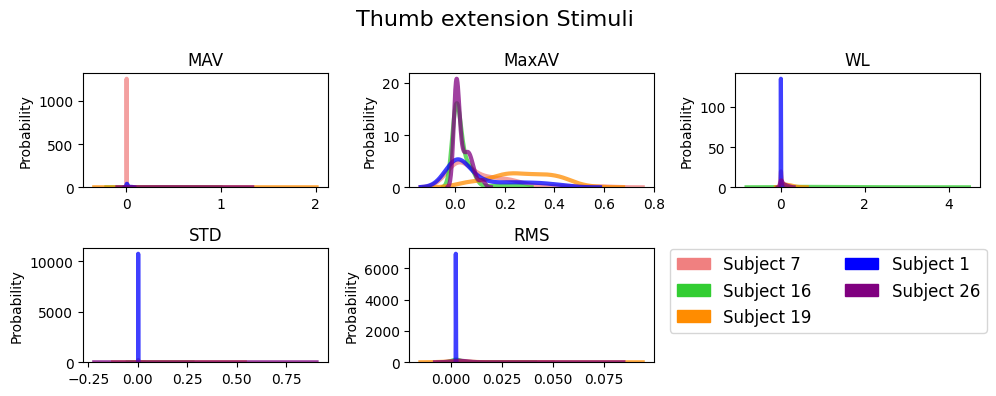

In [57]:
# Choose randomly N subjects 
subjects = np.random.choice(list(subject_features.keys()), size=5, replace=False)

# Define the time feature nams
time_features = ["MAV", "MaxAV", "WL", "STD", "RMS"]

# Define the colors for each subject
subj_col = ["lightcoral", "limegreen", "darkorange", "blue", "purple"]

for stimulus in range(1, len(id2stimulus)):

    # Setup the figure
    fig, axs = plt.subplots(2, 3, figsize=(10, 4), sharex=False, sharey=False)

    # Flatten the axes
    axs = axs.flatten()

    # Turn the last axis off
    axs[-1].axis("off")

    for si, subject_id in enumerate(subjects):

        # Get the data
        X_train, y_train, _, _, _, _ = subject_features[subject_id]

        # Get the data for the chosen stimulus
        X_train = X_train[y_train == stimulus]
        y_train = y_train[y_train == stimulus]

        for i, ax in enumerate(axs[:-1]):

            # Plot the distribution of the i-th feature
            #sns.histplot(x=X_train[:, i], ax=ax, color=subj_col[si], stat="probability", bins=12, kde=False, alpha=0.5);
            sns.kdeplot(x=X_train[:, i], ax=ax, color=subj_col[si], alpha=0.75, linewidth=3);

            # Set the title
            ax.set_title(time_features[i]);

            # Set the x and y labels
            ax.set_ylabel("Probability");

    # Add the legend of subjects
    legend_patches = [mpatches.Patch(color=color, label=f"Subject {subjects[i]}") for i, color in enumerate(subj_col)]
    fig.legend(handles=legend_patches, loc='lower right', ncol=2, bbox_to_anchor=(1, 0.15), fontsize="large")

    # Add the title for the entire figure
    fig.suptitle(f"{id2stimulus[stimulus]} Stimuli", fontsize=16)

    fig.tight_layout();

    # Save the figure
    folder_path = os.path.join("..", "figures", "features", "time", "kde")
    ext = "window" if USE_REP else "sliding"
    path = os.path.join(folder_path, f"{id2stimulus[stimulus]}_{ext}.png")
    fig.savefig(path, dpi=300, bbox_inches="tight");

print(f"✅ Plots saved to {folder_path}.")


It appeach that for majority of time features, the distribution is similar accross subjects. However, we can see that for `MaxAV` and `WL` the distribution is slightly different. Let's now instead use boxplots to see the distribution of the time features accross subjects for a single movement to get a more precise picture:

In [58]:
plt.ioff(); # Interactive plotting off --> to avoid showing the plots

In [59]:
# Choose randomly N subjects 
subjects = np.random.choice(list(subject_features.keys()), size=5, replace=False)

# Define the time feature names
time_features = ["MAV", "MaxAV", "WL", "STD", "RMS"]

# Define the colors for each subject
subj_col = ["lightcoral", "limegreen", "darkorange", "blue", "purple"]

for stimulus in range(1, len(id2stimulus)):

    # Setup the figure
    fig, axs = plt.subplots(len(time_features), len(subjects), figsize=(10, 10), sharex=True, sharey="row")

    for si, subject_id in enumerate(subjects):

        # Get the data
        X_train, y_train, _, _, _, _ = subject_features[subject_id]

        # Get the data for the chosen stimulus
        X_train = X_train[y_train == stimulus]
        y_train = y_train[y_train == stimulus]

        for i, ax in enumerate(axs):
            sns.boxplot(y=X_train[:, i], ax=axs[i, si], color=subj_col[si], linewidth=1.5, saturation=1, fliersize=3, orient="v");

            # Set the title
            if si == 0:
                axs[i, si].set_ylabel(time_features[i]);

        axs[0, si].set_title(f"Subject {subjects[si]}")

    fig.tight_layout();

    # Save the figure
    folder_path = os.path.join("..", "figures", "features", "time", "boxplot")
    ext = "window" if USE_REP else "sliding"
    path = os.path.join(folder_path, f"{id2stimulus[stimulus]}_{ext}.png")
    fig.savefig(path, dpi=300, bbox_inches="tight");

    plt.close(fig)

print(f"✅ Plots saved to {folder_path}.")

✅ Plots saved to ../figures/features/time/boxplot.


In [60]:
plt.ion() # Interactive plotting on

---